<a href="https://colab.research.google.com/github/baranshad/datascienceprojects/blob/main/COVIDprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import io
import requests
url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
s=requests.get(url).content
covid=pd.read_csv(io.StringIO(s.decode('utf-8')))

In [ ]:
covid.columns

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_',
       ...
       '2/9/22', '2/10/22', '2/11/22', '2/12/22', '2/13/22', '2/14/22',
       '2/15/22', '2/16/22', '2/17/22', '2/18/22'],
      dtype='object', length=771)

In [ ]:
covid.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,...,1/10/22,1/11/22,1/12/22,1/13/22,1/14/22,1/15/22,1/16/22,1/17/22,1/18/22,1/19/22,1/20/22,1/21/22,1/22/22,1/23/22,1/24/22,1/25/22,1/26/22,1/27/22,1/28/22,1/29/22,1/30/22,1/31/22,2/1/22,2/2/22,2/3/22,2/4/22,2/5/22,2/6/22,2/7/22,2/8/22,2/9/22,2/10/22,2/11/22,2/12/22,2/13/22,2/14/22,2/15/22,2/16/22,2/17/22,2/18/22
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",55869,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,162,162,162,162,162,162,163,163,163,163,163,163,163,163,163,165,163,163,166,166,166,166,167,168,168,170,170,170,171,171,173,173,173,176,176,176,177,181,181,183
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",223234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,603,603,603,603,603,603,605,605,605,605,607,608,608,608,608,610,608,608,612,612,612,612,614,616,616,623,623,623,624,624,626,626,626,626,626,626,629,630,631,634
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",24686,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,84,83,83,84,84,84,84,84,85,85,85,85,85,85,85,85,87,87,89,89,89,90,91,91,92
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",22394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,96,96,96,96,96,96,96,96,96,96,96,96,97,97,97,97,97,98,98,98,98
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",57826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,202,202,202,202,202,202,203,203,203,203,204,204,204,204,204,206,204,204,207,207,207,207,207,208,208,210,210,210,211,211,212,212,212,213,213,213,213,214,215,215


In [ ]:
covid_provice = covid.drop(['UID','iso2','iso3','code3','FIPS','Admin2','Country_Region','Lat','Long_','Combined_Key'], axis=1)

In [ ]:
covid_num = covid_provice.drop(['Province_State','Population'], axis=1)

In [ ]:
covid_num = covid_num.sum(axis=0)

In [ ]:
!pip install statsmodels --upgrade
!pip install -q neuralprophet
!pip install mplcyberpunk
!pip install neuralprophet

In [ ]:
import numpy as np
import requests
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from pandas_datareader import data
import datetime as dt
import urllib.request, json 
import os
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import mplcyberpunk
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
covid_num.shape

(760,)

In [ ]:
covid_daily = covid_num.diff(periods=1)

In [ ]:
covid_daily.head()

1/22/20    NaN
1/23/20    0.0
1/24/20    0.0
1/25/20    0.0
1/26/20    0.0
dtype: float64

In [ ]:
covidd = pd.Series(covid_daily,name="nums").to_frame()
covidd.dropna()
covidd = covidd.iloc[51: , :]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


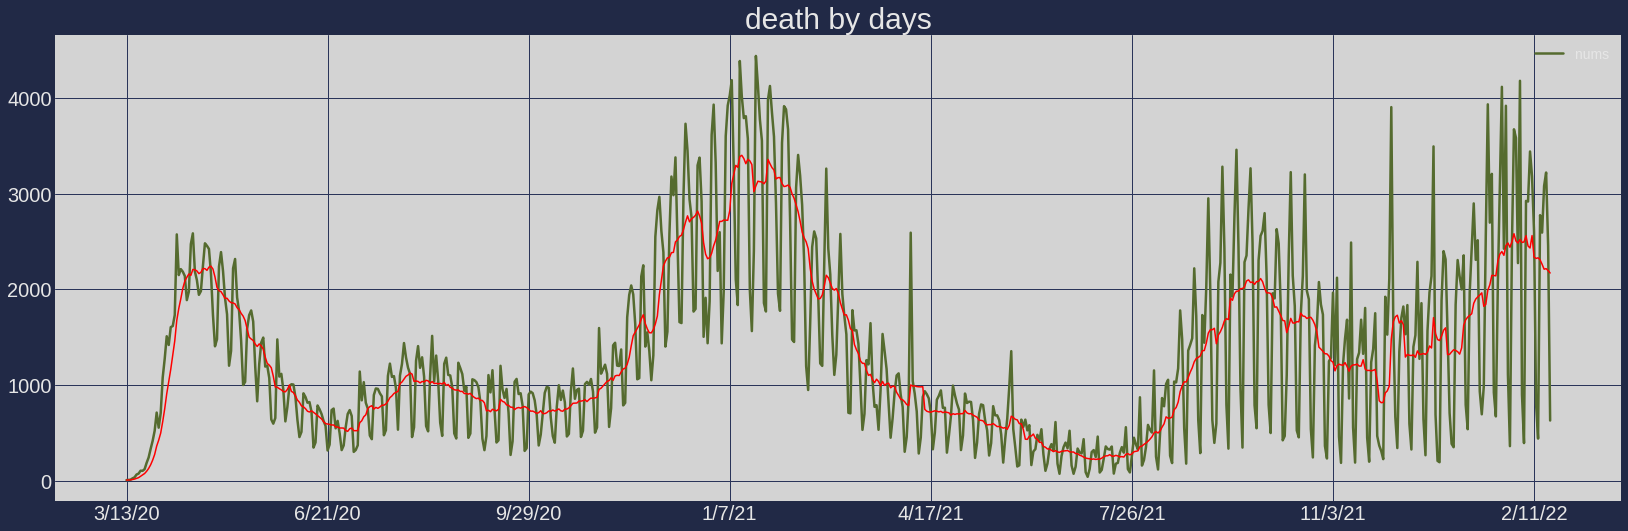

In [ ]:
covidma= covidd["nums"].rolling(7, min_periods=1).mean() ## add the moving average line to show the treand 
plt.style.use("cyberpunk")
_ = covidd.plot(style='', figsize=(25,8), color="darkolivegreen", lw=2.5)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.title("death by days", fontdict={'fontsize': 30})
plt.plot(covidma, 'k-', lw=1.5, color='red')

In [ ]:
covidd.reset_index(inplace=True)

In [ ]:
covidd.head()

,index,nums
0,3/13/20,7.0
1,3/14/20,9.0
2,3/15/20,11.0
3,3/16/20,25.0
4,3/17/20,36.0


In [ ]:
covidd['index']= pd.to_datetime(covidd['index']) 

In [ ]:
covidd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   709 non-null    datetime64[ns]
 1   nums    709 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.2 KB


In [ ]:
data = covidd.groupby([pd.Grouper(key='index')]).first().reset_index()
data = data.set_index('index')
split_date = '05-Feb-2022'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[(data.index > split_date)].copy()
data_train = data_train.reset_index().rename(columns={'index':'ds', 'nums':'y'})
data_test = data_test.reset_index().rename(columns={'index':'ds', 'nums':'y'})
data_train['ds'] = data_train['ds'].dt.tz_localize(None)
data_test['ds'] = data_test['ds'].dt.tz_localize(None)

In [ ]:
print(data_train.shape)
print(data_test.shape)

(695, 2)
(14, 2)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'death prediction')

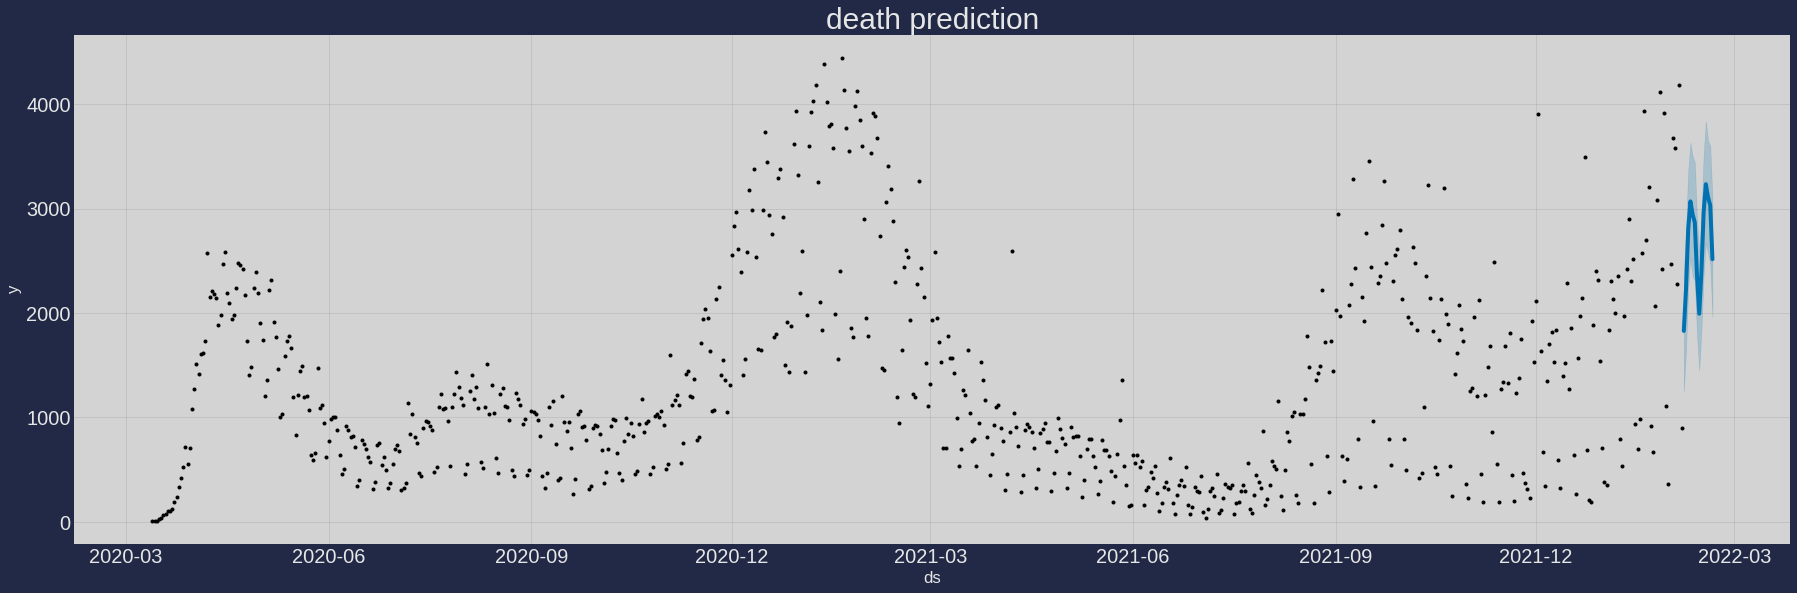

In [ ]:
# Setup and train model
model = Prophet(n_changepoints=100,
            changepoint_prior_scale=0.5,
            changepoint_range=0.95,
            weekly_seasonality=7)
model.fit(data_train)
data_test_fcst = model.predict(df=data_test)
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(25)
fig = model.plot(data_test_fcst, ax=ax)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.title("death prediction", fontdict={'fontsize': 30})

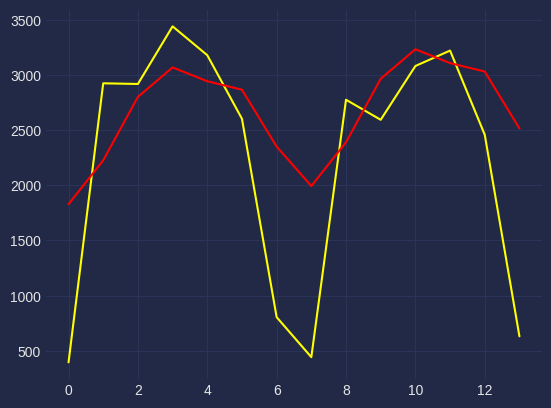

In [ ]:
plt.style.use('cyberpunk')
data_test_fcst = model.predict(df=data_test)
pyplot.plot(data_test.y, color = 'yellow', label='test')  
pyplot.plot(data_test_fcst.yhat, color='red', label='pred')
pyplot.show()

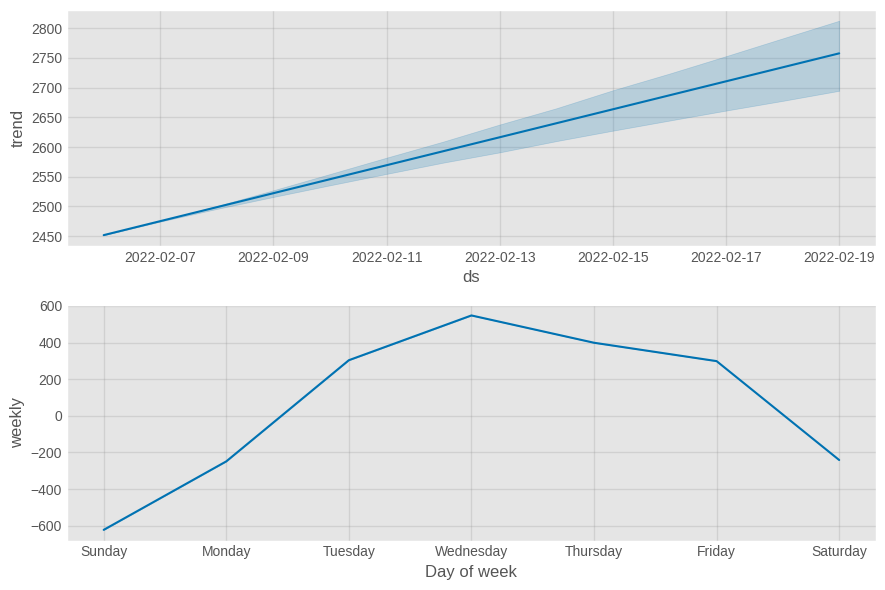

In [ ]:
plt.style.use('ggplot')
fig2 = model.plot_components(data_test_fcst)

In [ ]:
mean_squared_error(data_test.y, data_test_fcst.yhat)**0.5

919.8054018744018

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


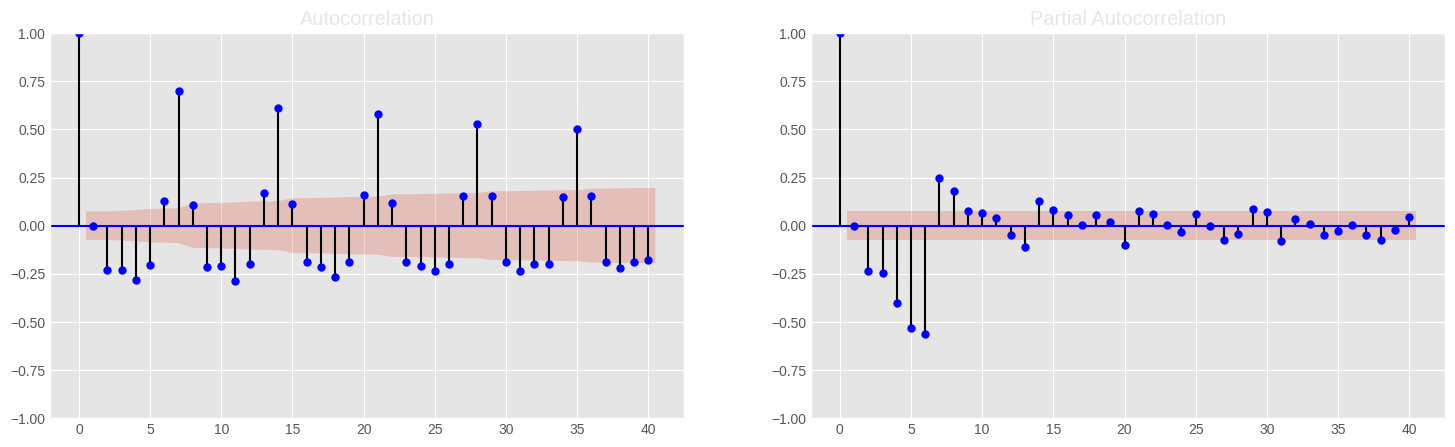

In [ ]:
numveh = covidd["nums"]
n = len(numveh)-1
z = np.arange(n)
for i in range(1, n+1):
    #print(i)
    z[i-1] = numveh[i]-numveh[i-1]

plt.style.use('ggplot')
fig, ax = plt.subplots(1,2,figsize=(18,5))
sm.graphics.tsa.plot_acf(z, lags=40, ax=ax[0], color="blue", vlines_kwargs={"colors": "black"})
sm.graphics.tsa.plot_pacf(z, lags=40, ax=ax[1], color="blue")
plt.show()

In [ ]:
train = covidd['nums'][:len(covidd)-14]
test = covidd['nums'][len(covidd)-14:]
armodel = AutoReg(train, lags=14).fit()
print(armodel.summary())

                            AutoReg Model Results                             
Dep. Variable:                   nums   No. Observations:                  695
Model:                    AutoReg(14)   Log Likelihood               -4986.797
Method:               Conditional MLE   S.D. of innovations            366.434
Date:                Sun, 20 Feb 2022   AIC                          10005.594
Time:                        18:05:30   BIC                          10077.971
Sample:                            14   HQIC                         10033.608
                                  695                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.3343     28.141      2.002      0.045       1.180     111.489
nums.L1        0.3548      0.038      9.323      0.000       0.280       0.429
nums.L2        0.0622      0.041      1.523      0.1

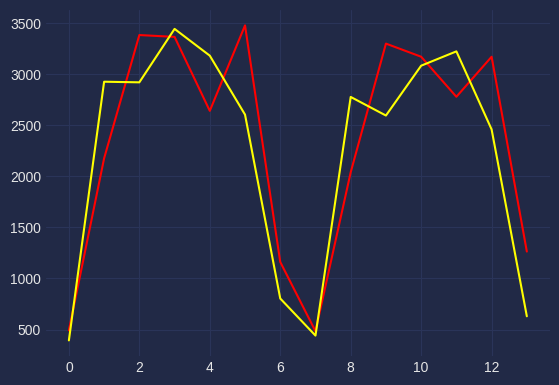

In [ ]:
plt.style.use('cyberpunk')
pred = armodel.predict(start = len(train), end=(len(covidd)-1), dynamic=False)
t1_armodel= pd.DataFrame(pred)
t2_armodel= pd.DataFrame(test)
t1_armodel=t1_armodel.reset_index(drop=True)
t2_armodel=t2_armodel.reset_index(drop=True)
pyplot.plot(t1_armodel, color="red")
pyplot.plot(t2_armodel, color="yellow")

In [ ]:
mean_squared_error(test, pred)**0.5

543.0624491970203

In [ ]:
data = covidd.groupby([pd.Grouper(key='index')]).first().reset_index()
data = data.set_index('index')
data = data.reset_index().rename(columns={'index':'ds', 'nums':'y'})
data['ds'] = data['ds'].dt.tz_localize(None)
df = data
df['nums_lag'] = df['y'].shift(14)
df.dropna()
df=df.iloc[20: , :]
df.tail(7)

,ds,y,nums_lag
702,2022-02-13,441.0,362.0
703,2022-02-14,2777.0,2466.0
704,2022-02-15,2595.0,3675.0
705,2022-02-16,3083.0,3585.0
706,2022-02-17,3223.0,2276.0
707,2022-02-18,2459.0,4182.0
708,2022-02-19,630.0,899.0


In [ ]:
m = NeuralProphet(
    n_forecasts=14,
    n_lags=14,
    learning_rate= 0.1,
)
m = m.add_lagged_regressor(names='nums_lag') #, only_last_value=True)
m.highlight_nth_step_ahead_of_each_forecast(3)
metrics = m.fit(df, freq="D")

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 198
INFO:NP.config:Auto-set epochs to 198
Epoch[198/198]: 100%|██████████| 198/198 [00:31<00:00,  6.36it/s, SmoothL1Loss=0.00579, MAE=242, RMSE=363, SmoothL1Loss-3=0.00523, MAE-3=227, RMSE-3=327, RegLoss=0]


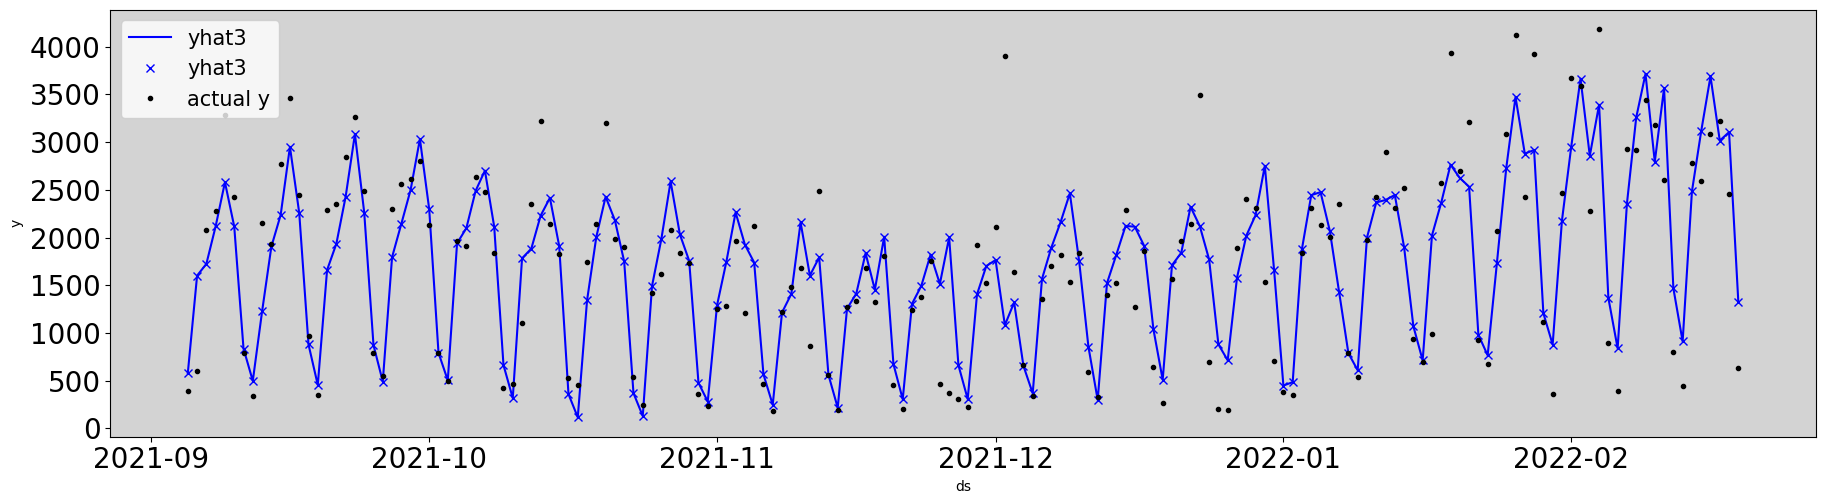

In [ ]:
forecast = m.predict(df)
plt.style.use("default")
m.plot(forecast[-7*24:],figsize=(18,5))
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(loc=2, prop={'size': 15})
plt.grid()
plt.show()

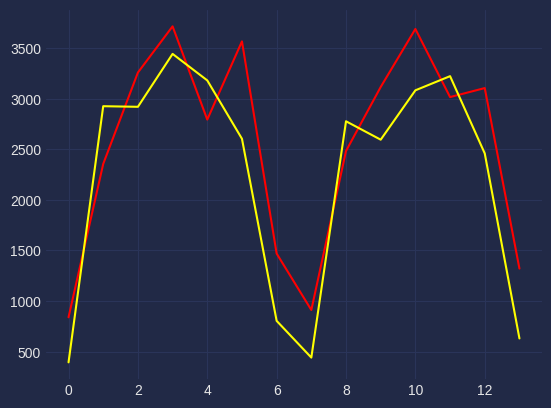

In [ ]:
t1= forecast.yhat3[-14:]
t2= df[-14:].y
t1=t1.reset_index(drop=True)
t2=t2.reset_index(drop=True)
plt.style.use('cyberpunk')
pyplot.plot(t1, color="red")
pyplot.plot(t2, color="yellow")

In [ ]:
mean_squared_error(t1, t2)**0.5

542.2611943158254

# **Neural Prophet Model**

In [ ]:
# define and fit model
#data_train = data_train.drop(['nums_lag'], axis=1)
set_random_seed(1234)
nm = NeuralProphet(n_changepoints=100,
                   daily_seasonality=False,                   
                   yearly_seasonality=False,
                   weekly_seasonality=7,
                   changepoints_range=0.9,
                   num_hidden_layers=1, # default: 0
                   seasonality_reg=1,
                   learning_rate = 0.01,
                   epochs = 100,
                   batch_size= 80,ar_sparsity=0.0001)
nm_result = nm.fit(data_train, freq='D')
future = nm.make_future_dataframe(data_test, periods = 7,
                                  n_historic_predictions=len(data_train))
forecast_2 = nm.predict(future)
print(len(forecast_2.dropna().yhat1))
mean_squared_error(forecast_2.dropna().y, forecast_2.dropna().yhat1)**0.5

INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
Epoch[100/100]: 100%|██████████| 100/100 [00:05<00:00, 19.38it/s, SmoothL1Loss=0.0204, MAE=539, RMSE=685, RegLoss=0.00151]
WARNING - (NP.forecaster._make_future_dataframe) - Insufficient data for 695 historic forecasts, reduced to 14.


14


810.1481610982385

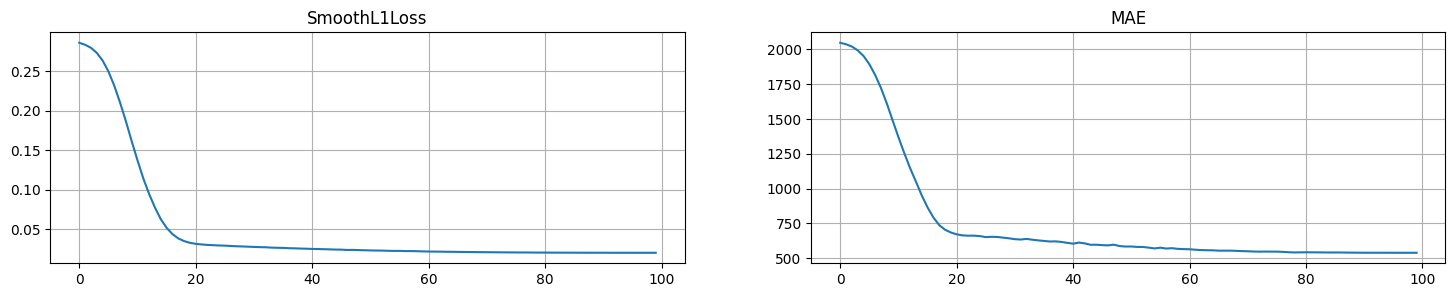

In [ ]:
plt.style.use("default")
plt.rcParams['figure.figsize'] = (18, 3) # resize plot window
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.plot(nm_result.SmoothL1Loss)
ax1.set_title('SmoothL1Loss')
ax1.grid()
ax2.plot(nm_result.MAE)
ax2.set_title('MAE')
ax2.grid()
plt.show()

In [ ]:
future = nm.make_future_dataframe(data_test, periods = 7,
                                  n_historic_predictions=len(data_train))
forecast_2 = nm.predict(future)

WARNING - (NP.forecaster._make_future_dataframe) - Insufficient data for 695 historic forecasts, reduced to 14.


In [ ]:
mean_squared_error(forecast_2.dropna().y, forecast_2.dropna().yhat1)**0.5

812.4983280051629

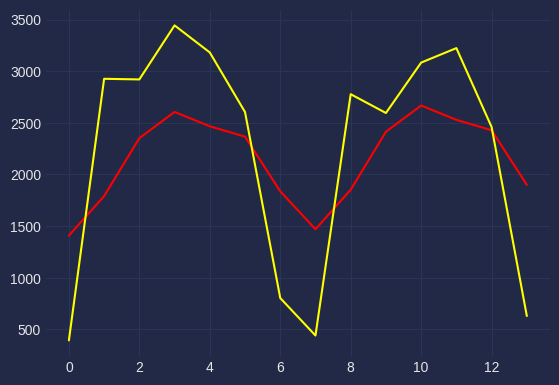

In [ ]:
plt.style.use('cyberpunk')
plt.rcParams["figure.figsize"] = (6.5,4.5)
pyplot.plot(forecast_2.dropna().yhat1, color="red")
pyplot.plot(forecast_2.dropna().y, color="yellow")

# **ARMIA model**

In [ ]:
#covidd= covidd.drop('nums_lag', axis=1)

In [ ]:
covidd.head()

,index,nums
0,2020-03-13,7.0
1,2020-03-14,9.0
2,2020-03-15,11.0
3,2020-03-16,25.0
4,2020-03-17,36.0


In [ ]:
covidd.shape

(709, 2)

In [ ]:
covidd.set_index('index', inplace=True)
train = covidd.iloc[:len(covidd)-14, :].values
test = covidd.iloc[len(covidd)-14:, :].values
len(test)

14

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    try:
        model = sm.tsa.arima.ARIMA(history, order=(7,1,2))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    except (ValueError, np.linalg.LinAlgError):
        pass
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
rmse = mean_squared_error(test, predictions)**0.5
print('Test MSE: %.3f' % rmse)

Test MSE: 428.043


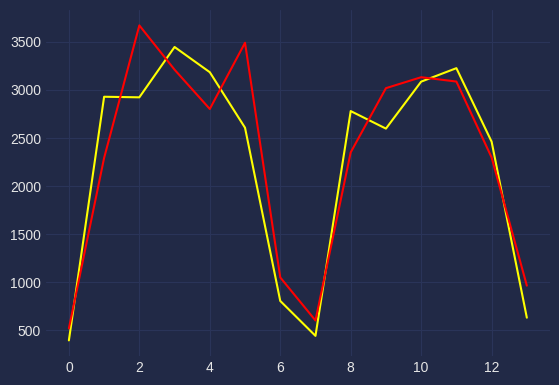

In [ ]:
pyplot.plot(test, color = 'yellow', label='test')   
pyplot.plot(predictions, color='red', label='pred')
pyplot.show()

In [ ]:
mean_squared_error(test, predictions)**0.5

428.04270019039586

# Summary all those models:
1, Prophet 
2, armodel
3, AR-net
4, Neural Prophet 
5, ARMIA 

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1,2,figsize=(18,5))
sm.graphics.tsa.plot_acf(z, lags=40, ax=ax[0], color="blue", vlines_kwargs={"colors": "black"})
sm.graphics.tsa.plot_pacf(z, lags=40, ax=ax[1], color="blue")
plt.show()

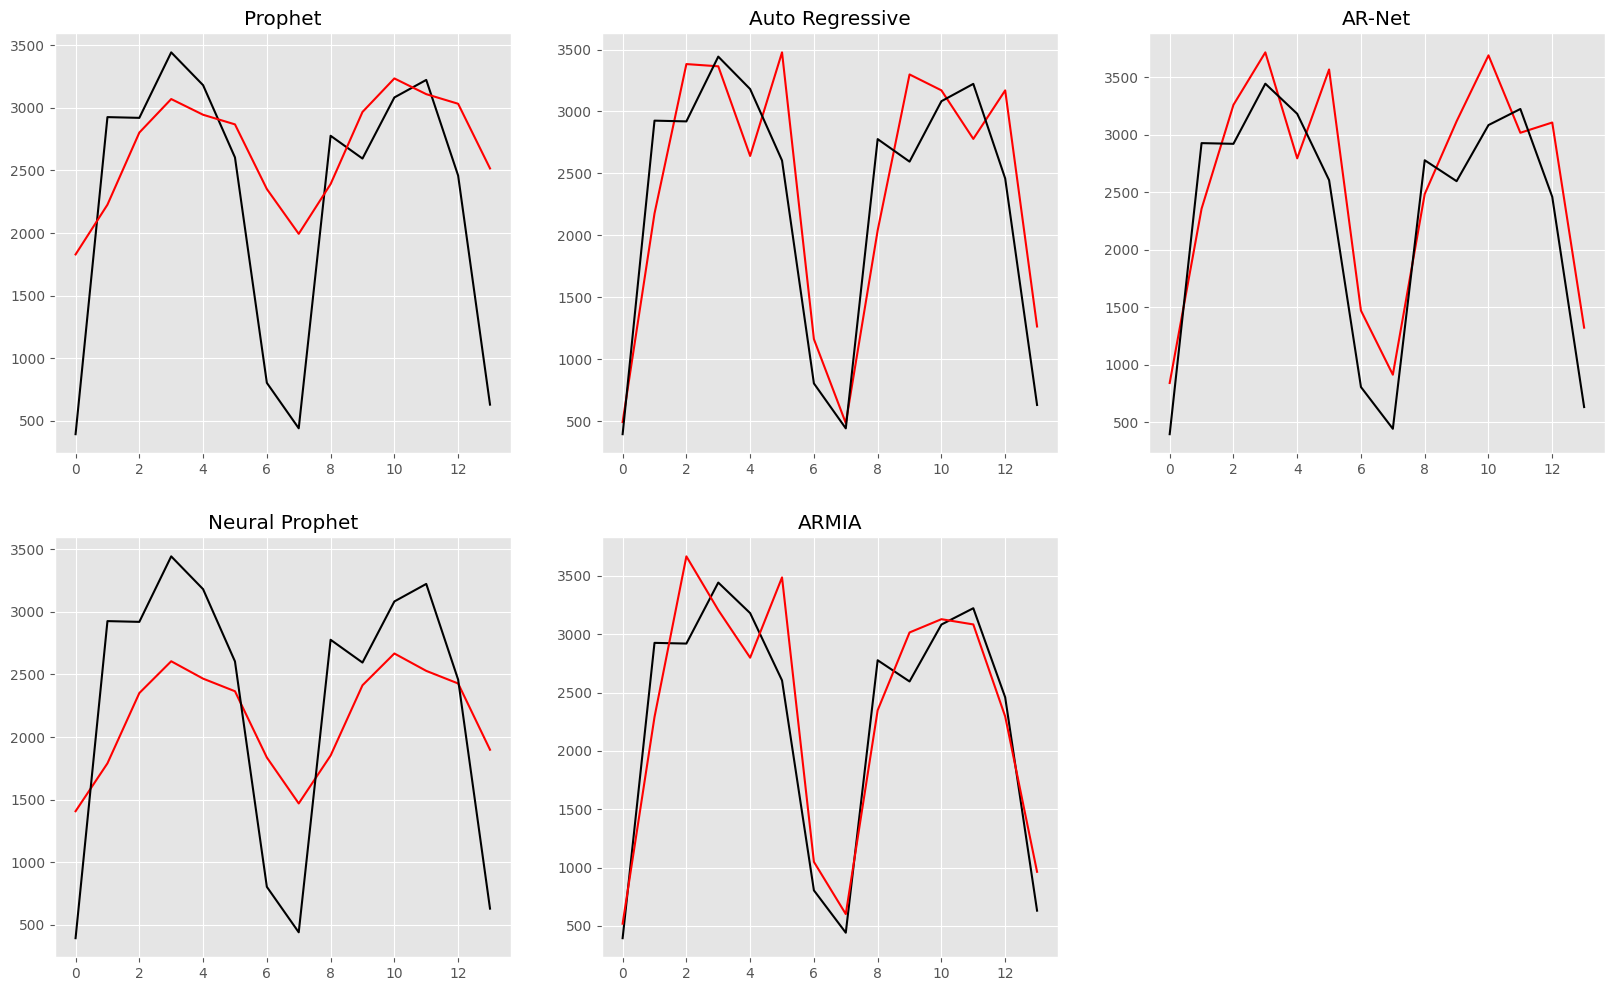

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(20,12))
#  subplot #1
plt.subplot(231)
plt.title('Prophet')
pyplot.plot(data_test.y, color = 'black', label='test')  
pyplot.plot(data_test_fcst.yhat, color='red', label='pred')
#  subplot #2
plt.subplot(2,3,2)
plt.title('Auto Regressive')
pyplot.plot(t1_armodel, color="red")
pyplot.plot(t2_armodel, color="black")
#  subplot #3
plt.subplot(233)
plt.title('AR-Net')
pyplot.plot(t1, color="red")
pyplot.plot(t2, color="black")
#  subplot #4
plt.subplot(2,3,4)
plt.title('Neural Prophet')
pyplot.plot(forecast_2.dropna().yhat1, color="red")
pyplot.plot(forecast_2.dropna().y, color="black")
#  subplot #5
plt.subplot(235)
plt.title('ARMIA')
pyplot.plot(test, color = 'black', label='test')   
pyplot.plot(predictions, color='red', label='pred')
plt.show()

In [ ]:
RMSE = [0]* 5 
RMSE[0] = mean_squared_error(data_test.y, data_test_fcst.yhat)**0.5
RMSE[1] = mean_squared_error(test, pred)**0.5
RMSE[2] = mean_squared_error(t1, t2)**0.5
RMSE[3] = mean_squared_error(forecast_2.dropna().y, forecast_2.dropna().yhat1)**0.5
RMSE[4] = mean_squared_error(test, predictions)**0.5

finalRMSE = pd.DataFrame(RMSE)
model=['Prophet', 'Auto Regressive', 'AR-Net', 'Neural Prophet','ARMIA']
finalRMSE['model'] = model

In [ ]:
print(finalRMSE)

            0            model
0  919.805402          Prophet
1  543.062449  Auto Regressive
2  542.261194           AR-Net
3  810.148161   Neural Prophet
4  428.042700            ARMIA
